# Priblem 1

In [1]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

## Dataset Ⅳ

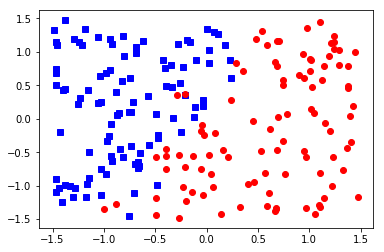

In [2]:
n = 200
x_d4 = 3 * (np.random.rand(n, 4) - 0.5)
y_d4 = (2 * x_d4[:, 0] - 1 * x_d4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_d4 = 2 * y_d4 -1

plt.plot(x_d4[y_d4 < 0, 0],  x_d4[y_d4 < 0, 1], 'bs')
plt.plot(x_d4[y_d4 > 0, 0],  x_d4[y_d4 > 0, 1], 'ro')

#print(x_d4)
#print(y_d4)
#print(x_d4[1,1])
#print(x_d4[y_d4 < 0, 0],  x_d4[y_d4 < 0, 1])

## 基底クラス

In [3]:
class Sigmoid:
    def __init__(self, dim, lr, lam):
        # 重みの初期化は下記のいずれか(損失の変化が比較できるので，今回はゼロで初期化)
        # self.weight = np.random.randn(dim)
        self.weight = np.zeros(dim)
        self.lr = lr
        self.lam = lam
        self.loss_history = np.zeros(0)

    def sigmoid(self, x, y):
        return 1 / (1 + np.exp(-y * np.dot(self.weight, x)))

    def grad(self, x, y):
        return (self.sigmoid(x, y) - 1.0) * y * x

    def hessian(self, x, y):
        _x = np.array([x])
        _x_t = _x.transpose()
        p = self.sigmoid(x, y)
        # 本当はy^2も掛ける必要があるが，今回の場合は1 or -1なので省略
        return p * (1 - p) * _x * _x_t * y * y
    
    def predict(self, x, y):
        return np.log(self.sigmoid(x, y)**-1) + self.lam * np.linalg.norm(x)
    
    def classifier(self, x):
        return 1 if np.dot(self.weight, x) > 0 else -1

## 最急降下法

In [4]:
class GradientMethod(Sigmoid):
    def __init__(self, dim=4, lr=0.1, lam=0.001):
        super(GradientMethod, self).__init__(dim, lr, lam)

    def train(self, x, y, epochs=10):
        self.loss_history = np.zeros(epochs)
        self.loss_history_2 = np.zeros(epochs)
        for epoch in range(epochs):
            _grad = np.zeros(4)
            _loss = 0.0
            
            for i in range(len(x)):
                _grad += self.grad(x[i], y[i])
                _loss += self.predict(x[i], y[i])
                #print("_loss = {}".format(_loss))
                
            #_grad = _grad / len(x) + 2 * self.lam * self.weight
            _grad = _grad / len(x) + 2 * self.lam * self.weight
            self.weight -= self.lr * _grad

            _loss = _loss / len(x)
            self.loss_history[epoch] = _loss
            #
            #self.loss_history_2[epoch] = self.weight
            #
            print("loss = {}".format(_loss)) 
            #print("weight = {}".format(self.weight))

In [5]:
epochs = 500
gm = GradientMethod()
gm.train(x_d4, y_d4, epochs)

loss = 0.694840354959743
loss = 0.6817715640104981
loss = 0.6692254615955406
loss = 0.6571800025306948
loss = 0.645613660534849
loss = 0.6345054891837879
loss = 0.623835170396499
loss = 0.6135830515010202
loss = 0.6037301719909611
loss = 0.5942582811052507
loss = 0.5851498473505914
loss = 0.5763880610463161
loss = 0.5679568309120205
loss = 0.5598407756455969
loss = 0.5520252113584774
loss = 0.5444961356502046
loss = 0.5372402090193148
loss = 0.5302447342244807
loss = 0.5234976341307684
loss = 0.5169874285019231
loss = 0.5107032101316776
loss = 0.5046346206453736
loss = 0.4987718262480049
loss = 0.4931054936457783
loss = 0.4876267663253141
loss = 0.48232724133719984
loss = 0.47719894669837665
loss = 0.47223431950022765
loss = 0.46742618478585507
loss = 0.4627677352403634
loss = 0.4582525117215397
loss = 0.45387438464479923
loss = 0.4496275362251799
loss = 0.44550644357023295
loss = 0.4415058626105338
loss = 0.4376208128489831
loss = 0.4338465629057715
loss = 0.4301786168327387
loss = 0.

loss = 0.22225615590924772
loss = 0.22209329571910666
loss = 0.22193128706852006
loss = 0.22177012318173353
loss = 0.22160979735658748
loss = 0.2214503029635011
loss = 0.22129163344447333
loss = 0.22113378231209996
loss = 0.22097674314860774
loss = 0.22082050960490357
loss = 0.220665075399641
loss = 0.22051043431829995
loss = 0.22035658021228444
loss = 0.22020350699803207
loss = 0.22005120865614017
loss = 0.219899679230506
loss = 0.21974891282747952
loss = 0.21959890361503118
loss = 0.21944964582193396
loss = 0.21930113373695564
loss = 0.21915336170806732
loss = 0.21900632414166343
loss = 0.21886001550179263
loss = 0.2187144303094033
loss = 0.21856956314160103
loss = 0.21842540863091459
loss = 0.21828196146457807
loss = 0.2181392163838213
loss = 0.2179971681831721
loss = 0.21785581170977014
loss = 0.2177151418626903
loss = 0.21757515359227836
loss = 0.21743584189949441
loss = 0.2172972018352703
loss = 0.21715922849987235
loss = 0.21702191704227758
loss = 0.21688526265955818
loss = 0.21

## ニュートン法

In [6]:
class NewtonMethod(Sigmoid):
    def __init__(self, dim=4, lr=0.1, lam=0.001):
        super(NewtonMethod, self).__init__(dim, lr, lam)
        self.dim = dim
            
    def train(self, x, y, epochs=10):
        self.loss_history = np.zeros(epochs)
        for epoch in range(epochs):
            _grad = np.zeros(4)
            _hesse = np.zeros((4,4))
            _loss = 0.0
            for i in range(len(x)):
                _grad += self.grad(x[i], y[i])
                _hesse += self.hessian(x[i], y[i])
                _loss += self.predict(x[i], y[i])
            _grad = _grad / len(x) + 2 * self.lam * self.weight
            _hesse = _hesse / len(x) + 2 * self.lam * np.identity(self.dim)
            self.weight -= (self.lr * np.matrix(_grad) * np.linalg.inv(_hesse)).A1
            #self.weight -= (np.matrix(_grad) * np.linalg.inv(_hesse)).A1

            _loss = _loss / len(x)
            self.loss_history[epoch] = _loss            
            print("loss = {}".format(_loss)) 

In [8]:
nm = NewtonMethod()
nm.train(x_d4, y_d4, epochs)

loss = 0.694840354959743
loss = 0.6314882460188884
loss = 0.57935408247028
loss = 0.5354141491596154
loss = 0.4977162041413486
loss = 0.4649285757368338
loss = 0.43610383077102016
loss = 0.4105450556660603
loss = 0.38772554023203165
loss = 0.36723815572272217
loss = 0.34876214955304763
loss = 0.33204061559517384
loss = 0.31686475527811875
loss = 0.3030625979226049
loss = 0.2904907320647575
loss = 0.2790281217952132
loss = 0.2685714016441893
loss = 0.2590312448465154
loss = 0.2503295297311633
loss = 0.24239711423911853
loss = 0.23517208497049416
loss = 0.2285983843995713
loss = 0.22262474424393403
loss = 0.2172038687053225
loss = 0.21229182145377012
loss = 0.2078475769911701
loss = 0.203832701942345
loss = 0.20021113588996722
loss = 0.19694904517997588
loss = 0.1940147269428585
loss = 0.1913785444519068
loss = 0.18901287879303263
loss = 0.18689208551557632
loss = 0.18499244832655226
loss = 0.18329212486270172
loss = 0.18177108204635237
loss = 0.180411020468215
loss = 0.17919528865101128

loss = 0.1688308886170152
loss = 0.16883088861701487
loss = 0.16883088861701462
loss = 0.16883088861701434
loss = 0.16883088861701398
loss = 0.1688308886170137
loss = 0.16883088861701356
loss = 0.1688308886170134
loss = 0.16883088861701318
loss = 0.16883088861701306
loss = 0.16883088861701293
loss = 0.16883088861701284
loss = 0.1688308886170127
loss = 0.16883088861701265
loss = 0.16883088861701256
loss = 0.1688308886170125
loss = 0.16883088861701245
loss = 0.1688308886170124
loss = 0.16883088861701231
loss = 0.16883088861701226
loss = 0.1688308886170122
loss = 0.16883088861701215
loss = 0.16883088861701212
loss = 0.16883088861701206
loss = 0.16883088861701206
loss = 0.16883088861701204
loss = 0.168830888617012
loss = 0.168830888617012
loss = 0.16883088861701195
loss = 0.16883088861701195
loss = 0.16883088861701193
loss = 0.16883088861701193
loss = 0.16883088861701193
loss = 0.16883088861701193
loss = 0.16883088861701193
loss = 0.1688308886170119
loss = 0.16883088861701182
loss = 0.1688

## 確認用
学習データをそのままpredictしているので，汎化性を確認するものでないことに注意

あくまで，学習データにフィットしているか確認するもの

In [9]:
def train_data_accuracy(model, x, y, debug=False):
    count = 0
    for i in range(len(x)):
        if debug:
            print(model.classifier(x[i]), y[i])
        count = count + 1 if model.classifier(x[i]) == y[i] else count
    print(count / len(x))
    
train_data_accuracy(gm, x_d4, y_d4)
train_data_accuracy(nm, x_d4, y_d4)

0.945
0.94


## J(w)の変化の比較

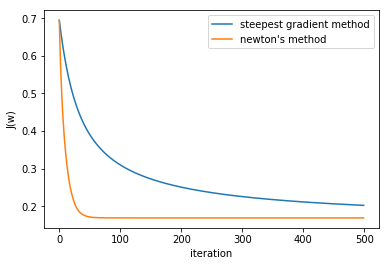

In [10]:
x_axis = np.arange(epochs)
plt.xlabel("iteration")
plt.ylabel("J(w)")
plt.plot(x_axis, gm.loss_history, label="steepest gradient method")
plt.plot(x_axis, nm.loss_history, label="newton's method")
plt.legend()
plt.show()

## J(w) - J(w^)の変化の比較

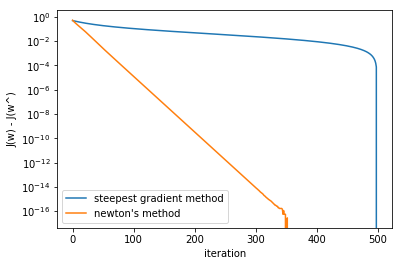

In [11]:
#epochs = 500
gm_loss_history_2 = np.zeros(epochs)
nm_loss_history_2 = np.zeros(epochs)

#print(gm.loss_history[epochs - 1])

for epoch in range(epochs):
    gm_loss_history_2[epoch] = gm.loss_history[epoch] - gm.loss_history[epochs - 1]
    nm_loss_history_2[epoch] = nm.loss_history[epoch] - nm.loss_history[epochs - 1]
    

x_axis = np.arange(epochs)
plt.xlabel("iteration")
plt.ylabel("J(w) - J(w^)")
plt.semilogy(x_axis, gm_loss_history_2, label="steepest gradient method")
plt.semilogy(x_axis, nm_loss_history_2, label="newton's method")
#plt.plot(x_axis, gm_loss_history_2, label="steepest gradient method")
#plt.plot(x_axis, nm_loss_history_2, label="newton's method")
#plt.yscale('log')
plt.legend()
plt.show()

## DatasetⅤ

In [17]:
# dataset 5
n = 200
x_d5 = 3 * (np.random.rand(n, 4) - 0.5)
W = np.array([[ 2,  -1, 0.5,],
              [-3,   2,   1,],
              [ 1,   2,   3]])
y_d5 = np.argmax(np.dot(np.hstack([x_d5[:,:2], np.ones((n, 1))]), W.T)
                        + 0.5 * np.random.randn(n, 3), axis=1)

#plt.plot(x_d4[y_d4 < 0, 0],  x_d4[y_d4 < 0, 1], 'bs')
#plt.plot(x_d4[y_d4 > 0, 0],  x_d4[y_d4 > 0, 1], 'ro')

#print(x_d5)
#print(y_d5)
#print(x_d5[1,1])
#print(x_d4[y_d4 < 0, 0],  x_d4[y_d4 < 0, 1])

## 最急降下法

In [18]:
epochs = 200
gm = GradientMethod()
gm.train(x_d5, y_d5, epochs)

loss = 0.6948584031963111
loss = 0.6904698063151122
loss = 0.6864738054041365
loss = 0.6828325459359347
loss = 0.6795116234835719
loss = 0.6764798806664624
loss = 0.6737091807036186
loss = 0.6711741706487474
loss = 0.6688520440057931
loss = 0.6667223096053583
loss = 0.6647665713598937
loss = 0.6629683217596937
loss = 0.6613127506515833
loss = 0.659786569880954
loss = 0.6583778537023985
loss = 0.657075894409859
loss = 0.6558710723496504
loss = 0.6547547393147619
loss = 0.6537191142417923
loss = 0.6527571901159784
loss = 0.651862651014952
loss = 0.6510297982732056
loss = 0.6502534848160657
loss = 0.6495290567865888
loss = 0.6488523016660451
loss = 0.6482194021648918
loss = 0.6476268952342455
loss = 0.6470716356163959
loss = 0.6465507634161831
loss = 0.6460616752328263
loss = 0.6456019984440234
loss = 0.6451695682810759
loss = 0.6447624073757285
loss = 0.6443787074967158
loss = 0.6440168132271034
loss = 0.6436752073627815
loss = 0.6433524978383257
loss = 0.6430474060092142
loss = 0.642758

## ニュートン法

In [19]:
nm = NewtonMethod()
nm.train(x_d5, y_d5, epochs)

loss = 0.6948584031963111
loss = 0.6845507968932739
loss = 0.6761629291372835
loss = 0.6692928050830659
loss = 0.6636397388746975
loss = 0.6589731585118667
loss = 0.6551126527568285
loss = 0.6519147438495255
loss = 0.6492638378735723
loss = 0.6470658541533716
loss = 0.6452436212066633
loss = 0.6437334672016722
loss = 0.6424826372749856
loss = 0.6414472963072673
loss = 0.6405909555825837
loss = 0.6398832132364778
loss = 0.6392987321393571
loss = 0.6388164012819239
loss = 0.6384186418083867
loss = 0.638090829104096
loss = 0.6378208094145985
loss = 0.6375984944168139
loss = 0.6374155206815963
loss = 0.6372649635252956
loss = 0.6371410966546309
loss = 0.6370391904688448
loss = 0.6369553430312641
loss = 0.6368863386484853
loss = 0.636829529758704
loss = 0.636782738470632
loss = 0.6367441746373903
loss = 0.6367123678142008
loss = 0.6366861108476
loss = 0.6366644131870081
loss = 0.6366464623045509
loss = 0.6366315918622236
loss = 0.6366192554821982
loss = 0.6366090051609793
loss = 0.636600473

## J(w)の変化の比較

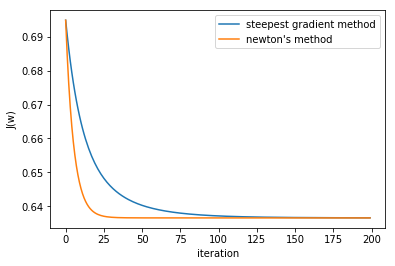

In [20]:
x_axis = np.arange(epochs)
plt.xlabel("iteration")
plt.ylabel("J(w)")
plt.plot(x_axis, gm.loss_history, label="steepest gradient method")
plt.plot(x_axis, nm.loss_history, label="newton's method")
plt.legend()
plt.show()

## J(w) - J(w^)の変化の比較

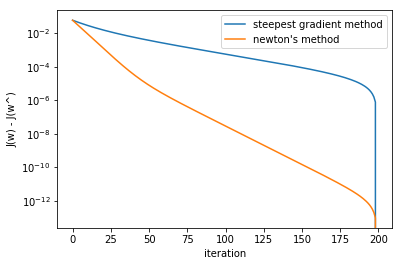

In [21]:
#epochs = 200
gm_loss_history_3 = np.zeros(epochs)
nm_loss_history_3 = np.zeros(epochs)

#print(gm.loss_history[epochs - 1])

for epoch in range(epochs):
    gm_loss_history_3[epoch] = gm.loss_history[epoch] - gm.loss_history[epochs - 1]
    nm_loss_history_3[epoch] = nm.loss_history[epoch] - nm.loss_history[epochs - 1]
    

x_axis = np.arange(epochs)
plt.xlabel("iteration")
plt.ylabel("J(w) - J(w^)")
plt.semilogy(x_axis, gm_loss_history_3, label="steepest gradient method")
plt.semilogy(x_axis, nm_loss_history_3, label="newton's method")
#plt.plot(x_axis, gm_loss_history_2, label="steepest gradient method")
#plt.plot(x_axis, nm_loss_history_2, label="newton's method")
#plt.yscale('log')
plt.legend()
plt.show()